## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images to predict the 6 plant properties. The images are processed using the EfficientNet-B0 architectures, whose weights were pretrained on the ImageNet-1K dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-04-28 02:49:34.624636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 02:49:34.624732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 02:49:34.758921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the data

In [2]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [3]:
# targets
target_desc = pd.read_table(path / 'target_name_meta.tsv', sep='\t')
targets = target_desc['trait_ID'].tolist()
for row in target_desc.iterrows():
    print(row[1].tolist())

['X4', 'Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume) ']
['X11', 'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA) ']
['X18', 'Plant height ']
['X26', 'Seed dry mass ']
['X50', 'Leaf nitrogen (N) content per leaf area ']
['X3112', 'Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded) ']


In [4]:
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

## Target Preprocessing

In [5]:
X = train['img_path'].astype(str).values
Y = train[target_cols]

In [6]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
X = X[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


In [7]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)

## Image preprocessing functions

In [8]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing needed for efficient net
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, targets):
    return process_image_from_file(file_path), targets


## Create training and validation sets

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_sc, random_state=2, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train.astype(np.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val.astype(np.float32)))


# preprocess and batch
train_ds = train_ds.map(process_path).batch(256)
val_ds = val_ds.map(process_path).batch(256)

## Model architecture

In [10]:
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Input(shape = (224, 224, 3), name="input"),
    # augmentation layers
    keras.Sequential([
        keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
        keras.layers.RandomTranslation(
            height_factor=0.1, width_factor=0.1, interpolation='nearest'
        )
    ], name='augmentation'),
    EfficientNetB0(include_top=False, weights='imagenet', pooling='avg'),
    # output layers
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, name='fc_hidden'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(6, name='raw_output')
])

# fix efficientnet weights 
model.get_layer('efficientnetb0').trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss= keras.losses.MeanAbsoluteError(),
    metrics=[keras.metrics.R2Score()]
)

print(model.summary())

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_hidden (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ raw_output (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,073 (16.71 MB)

 Trainable params: 329,990 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

None


## Training

In [11]:
NUM_EPOCHS= 10
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/10


2024-04-28 02:50:01.061668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


156/156 ━━━━━━━━━━━━━━━━━━━━ 117s 655ms/step - loss: 0.7957 - r2_score: -0.2642 - val_loss: 0.6043 - val_r2_score: 0.1162
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.6232 - r2_score: 0.0593 - val_loss: 0.5795 - val_r2_score: 0.1331
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5895 - r2_score: 0.0943 - val_loss: 0.5681 - val_r2_score: 0.1303
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5756 - r2_score: 0.1073 - val_loss: 0.5674 - val_r2_score: 0.1364
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5695 - r2_score: 0.1149 - val_loss: 0.5636 - val_r2_score: 0.1315
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5667 - r2_score: 0.1175 - val_loss: 0.5619 - val_r2_score: 0.1406
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5629 - r2_score: 0.1227 - val_loss: 0.5631 - val_r2_score: 0.1449
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 0.5607 - r2_score: 0.1274 - v

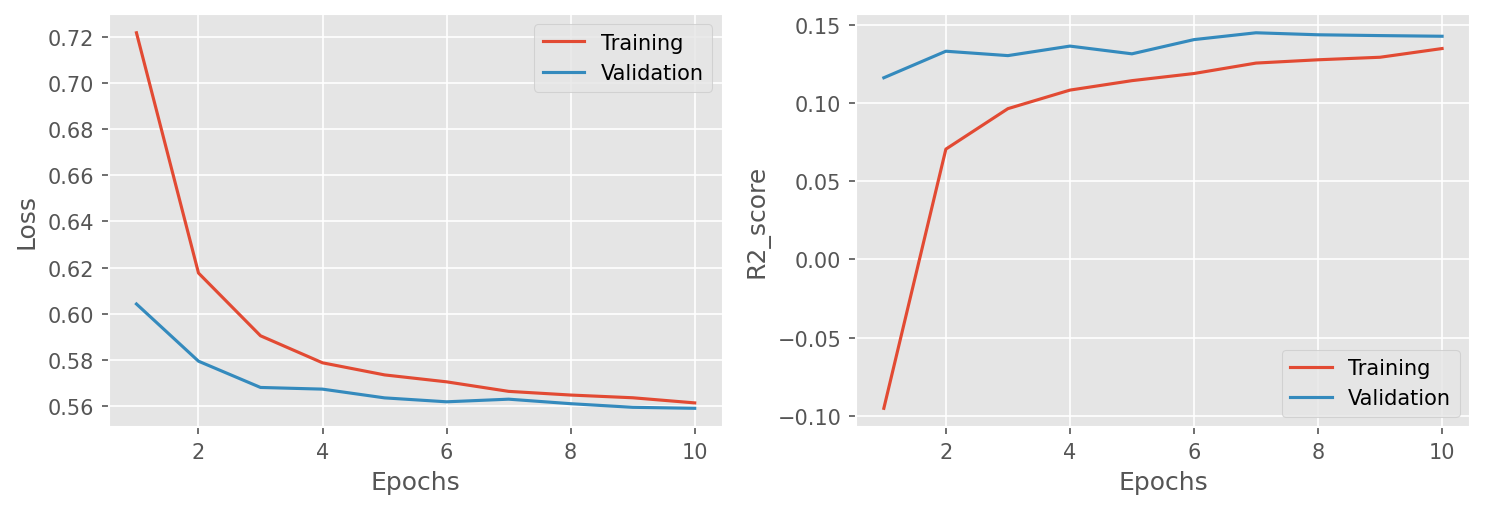

In [12]:
# plot training history
metrics = ['loss','r2_score']

fig,axs = plt.subplots(1,len(metrics),figsize=(5*len(metrics),3.5),dpi=150)

for i,metric in enumerate(metrics):
    
    _ = axs[i].plot(1 + np.arange(NUM_EPOCHS), history.history[f'{metric}'],label='Training')
    _ = axs[i].plot(1 + np.arange(NUM_EPOCHS), history.history[f'val_{metric}'],label='Validation')
    _ = axs[i].legend()
    _ = axs[i].set_ylabel(metric.capitalize())
    _ = axs[i].set_xlabel('Epochs')

fig.tight_layout()
fig.savefig('training_history.png',bbox_inches='tight')
fig.savefig('training_history.pdf',bbox_inches='tight')

In [13]:
# save weights
model.save_weights("model.weights.h5")

## Predictions on Test Data

In [14]:
test_ds = tf.data.Dataset.from_tensor_slices((test['img_path'].astype(str).values,))
test_ds = test_ds.map(process_image_from_file).batch(256)
predictions = model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 623ms/step


In [15]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [16]:
submission.head()

,id,X4,X11,X18,X26,X50,X3112
0,201238668,0.525824,16.377666,0.353691,2.442922,1.405929,287.644165
1,202310319,0.383827,17.919853,0.357016,1.518218,1.240135,681.283508
2,202604412,0.537415,14.141653,0.818906,4.138825,1.686285,486.415039
3,201353439,0.556735,16.835501,1.524221,6.129819,1.238296,1977.217041
4,195351745,0.472050,13.802444,0.193806,-0.071849,1.478061,258.506348
